In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [16]:
start = '2010-01-01'
end = '2023-12-31'
stock = 'BRK-B'

data = yf.download(stock, start, end)
data.to_csv('brk-b.csv', index=True)

[*********************100%%**********************]  1 of 1 completed


In [17]:
# Pad NA values
data.fillna( method ='pad', inplace = True)
data

C:\Users\LAB104\AppData\Local\Temp\ipykernel_1952\4093306910.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna( method ='pad', inplace = True)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,66.000000,66.500000,65.919998,66.220001,66.220001,1575000
2010-01-05,66.389999,66.589996,66.150002,66.540001,66.540001,1310000
2010-01-06,66.500000,66.500000,66.199997,66.199997,66.199997,1760000
2010-01-07,66.199997,66.510002,66.139999,66.459999,66.459999,1505000
2010-01-08,66.480003,66.480003,66.300003,66.440002,66.440002,1500000
...,...,...,...,...,...,...
2023-12-22,356.500000,358.260010,355.410004,356.470001,356.470001,2332200
2023-12-26,356.899994,357.769989,356.079987,356.829987,356.829987,1964400
2023-12-27,355.929993,357.079987,355.500000,356.950012,356.950012,2478500


In [18]:
# Split train test data
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.65)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.65): len(data)])
print('Train: ', data_train.shape[0])
print('Test: ', data_test.shape[0])

Train:  2289
Test:  1233


In [19]:
# Scale training data
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])
x, y = np.array(x), np.array(y)

In [20]:
# Build model
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape = ((x.shape[1], 1))))
model.add(LSTM(units = 50, activation='relu', return_sequences = True))
model.add(LSTM(units = 50, activation = 'relu', return_sequences = False))
model.add(Dense(units = 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x, y, epochs = 10, batch_size = 64, verbose = 1)

Epoch 1/10
35/35 [==============================] - 7s 78ms/step - loss: 0.0655
Epoch 2/10
35/35 [==============================] - 3s 78ms/step - loss: 0.0032
Epoch 3/10
35/35 [==============================] - 3s 87ms/step - loss: 8.8751e-04
Epoch 4/10
35/35 [==============================] - 3s 81ms/step - loss: 7.2378e-04
Epoch 5/10
35/35 [==============================] - 3s 79ms/step - loss: 6.7448e-04
Epoch 6/10
35/35 [==============================] - 3s 82ms/step - loss: 6.6716e-04
Epoch 7/10
35/35 [==============================] - 3s 78ms/step - loss: 6.3663e-04
Epoch 8/10
35/35 [==============================] - 3s 86ms/step - loss: 6.4633e-04
Epoch 9/10
35/35 [==============================] - 3s 85ms/step - loss: 6.4541e-04
Epoch 10/10
35/35 [==============================] - 3s 83ms/step - loss: 6.0221e-04


In [35]:
# Data for first piece of testing data
past_100_days = data_train.tail(100)
data_test = pd.concat([past_100_days, data_test], ignore_index=True)
data_test_scale  = scaler.fit_transform(data_test)
data_test

,Close
0,214.889999
1,216.369995
2,216.289993
3,218.300003
4,220.949997
...,...
1428,356.470001
1429,356.829987
1430,356.950012
1431,357.570007


In [36]:
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)
x.shape

(1333, 100, 1)

In [37]:
y_predict = model.predict(x)
print(y_predict.shape)

42/42 [==============================] - 1s 19ms/step
(1333, 1)


In [38]:
float_y = y.astype(float)
float_y_predict = y_predict.astype(float)
r2_score(y, y_predict)
print('r2 score', r2_score(y, y_predict))

r2 score 0.9680260278893672


In [39]:
# 假設y_true是一個NumPy陣列
# 找到y_true陣列中等於零的元素的索引
zero_indices = np.where(y == 0)[0]

if len(zero_indices) > 0:
    print("y_true陣列包含零值，位置在:", zero_indices)
else:
    print("y_true陣列不包含零值")


y_true陣列包含零值，位置在: [382]


In [40]:
# coding=utf-8
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

# MSE
print(metrics.mean_squared_error(y, y_predict))
# RMSE
print(np.sqrt(metrics.mean_squared_error(y, y_predict)))
# MAE
print(metrics.mean_absolute_error(y, y_predict))
# MAPE
print(mape(y, y_predict))
# SMAPE
print(smape(y, y_predict))

0.002221004569980106
0.0471275351570619
0.03530242085884267
inf
65.77025124526894


C:\Users\LAB104\AppData\Local\Temp\ipykernel_1952\2182350700.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


In [41]:
y_reshaped = y.reshape(-1, 1)
yi=scaler.inverse_transform(y_reshaped)
y_predict=scaler.inverse_transform(y_predict)

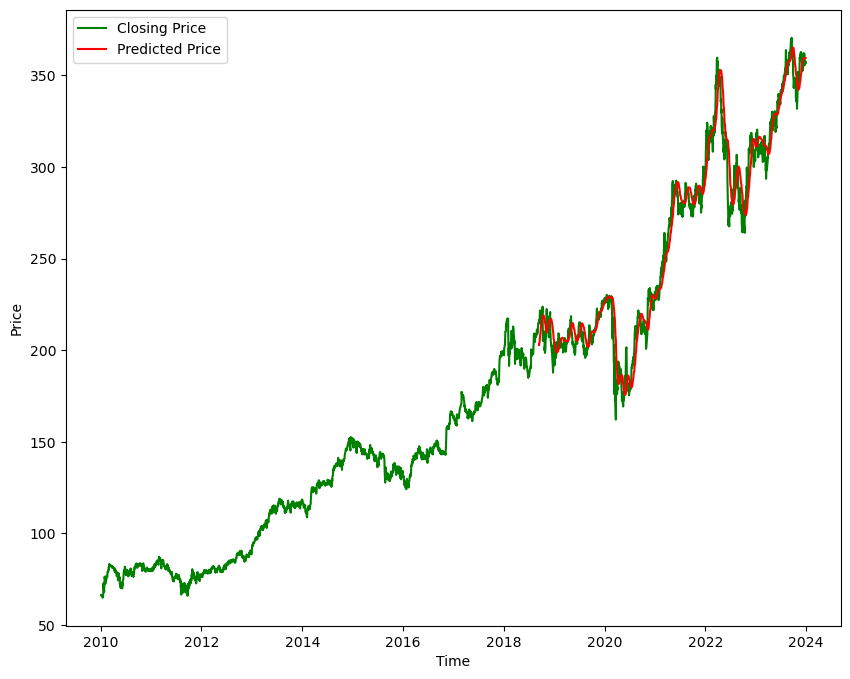

In [96]:
test_period = pd.DataFrame(data[int(len(data)*0.65-100): len(data)])
test_period['y_predict'] = y_predict
plt.figure(figsize=(10, 8))
plt.plot(data['Close'], 'g', label='Closing Price')
plt.plot(test_period['y_predict'], 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()